# Monitoring Machine Learning Models with Grafana: A Beginner's Guide

## Introduction

 Machine learning projects don't end when you deploy a model into production. Even after deployment, you must monitor it constantly to ensure its accuracy doesn't go down over time. This is where tools like Grafana can be helpful with its powerful visualization and monitoring capabilities. It allows data scientists and ML engineers keep a close eye on their production model's performance.

 This article aims to introduce you to the world of machine learning model monitoring through Grafana using the example of a simple regression model. By the end, we will have a monitoring system set up that can send alerts when production performance drops. 

 Let's get started!

## Model Monitoring Fundamentals

Before we start talking about Grafana and how to use it, let's understand why machine learning models fail in production without monitoring. Two key concepts that often lead to model degradation are data drift and concept drift.

### Data drift

![](images/robot.jpg)

Imagine you've trained a robot to sort apples based on their size and color. The robot can detect ripe red apples of certain size range. Now, let's say next year, the orchard starts producing new type of apples that are green when they are ripe. Suddenly, the robot starts making mistakes because the data it is receiving (green apples) is different from what it was trained on (red apples). 

This phenomenon is called __data drift__ in machine learning. It happens when the distribution of production data differs significantly from the training data. This often leads to horrible model performance because it is making predictions on new type of data that involves outdated or irrelevant patterns. 

Monitoring for data drift helps us identify when our model's inputs change in production, indicating that we might need to retrain our model on more recent data.

### Concept drift

Let's revisit our apple-sorting robot. This time, imagine that consumer preferences change, and people start preferring slightly underripe apples. The definition of a "good apple" has changed, even though the apples look the same. 

This is concept drift in machine learning. It occurs when the relationship between the input features and the target variable changes over time. In other words, the rules of the game change. In our ML context:

- The model's logic: The relationships and patterns the model has learned.
- The real-world relationship: How input features actually relate to the target variable in the current environment.

Concept drift happens when these two diverge, even if the input data itself hasn't changed much.

Monitoring for concept drift helps us identify when our model's fundamental assumptions are no longer valid, indicating that we might need to rethink our feature engineering or even model architecture.

--------

Both data drift and concept drift highlight the importance of continuous monitoring in machine learning. Models that perform well in training and initial deployment can degrade over time as the world around them changes. By implementing robust monitoring systems we can:

1. Detect changes early.
2. Understand the nature of the drift.
3. Take appropriate actions such as retraining the model or updating our features. 

That's why we need tools like Grafana that provide us methods to visualize these drifts and set up alerts when our model's performance starts to go down.

In the next sections, we'll explore how to set up Grafana to monitor for these types of drifts and other key performance indicators of our machine learning model.

## The Toolstack We Will Use

### Grafana

Grafana is an open-source observability platform with features for analytics and interactive visualizations. It can be connected to various data sources (the backend) of any application and give insight into its performance through charts, graphs and alerts. Given its characteristics, it can be a good candidate for building a ML monitoring system. 

Here are its key features for this context:
- Customizable dashboards: Create visually-appealing, real-time dashboards to display model performance metrics.
- Data source integration: Connect to different data sources, including Prometheus, to fetch and visualize performance metrics.
- Alerting system: Set up alerts (email, slack, SMS) based on custom thresholds to notify you in case of drifts.
- Time series analytics: Analyze trends and patterns in your model's performance over time.



### Prometheus

Prometheus is a systems monitoring and alerting toolkit. It's designed for reliability and scalability, making it ideal for monitoring distributed systems. Prometheus is often used with Grafana because:
- Efficient data storage: it uses a time-series database optimized for storing and querying metrics data.
- Pull-based architecture: it actively scrapes metrics from configured targets for data freshness and reliability.
- Powerful query language: Prometheus has its query language (PromQL) for complex scraping queries and aggregations of metrics data.



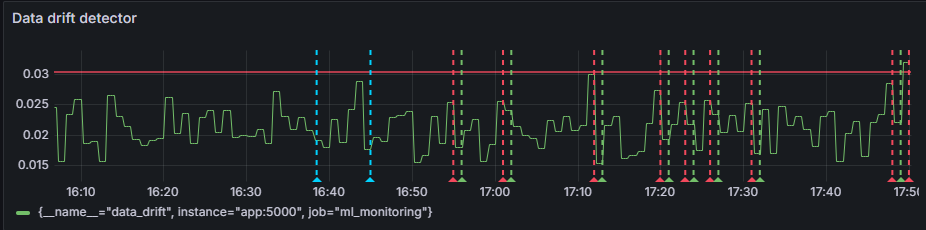

### How Grafana and Prometheus Work Together
For a model monitoring system, Grafana and Prometheus can create a powerful tandem. Prometheus is for data collection and storage:

- Scrapes metrics from your ML application endpoints.
- Stores the collected data in its time-series database.
- Provides a query interface (PromQL) for data retrieval. 

Grafana is for visualization and alerting:
- Connects to Prometheus as a data source
- Queries Prometheus with PromQL
- Visualizes the metrics in customizable dashboards
- Monitors metrics and triggers alerts based on defined conditions. 

### Docker and Docker Compose



It is hard to imagine monitoring systems without Docker. It provides containerization, ensuring consistent environments across development and production. We won't go into the details of Docker's importance but you can read more about it in [this separate article](https://www.datacamp.com/tutorial/docker-for-data-science-introduction). 

We also have Docker Compose which simplifies the process of defining and running multi-container applications, making it easier to set up and manage our monitoring stack alongside our ML application.

If you are unfamiliar with Docker, check out our [Containerization Concepts](https://www.datacamp.com/courses/containerization-and-virtualization-concepts) and [Introduction to Docker](https://www.datacamp.com/courses/introduction-to-docker) courses. 

### Scikit-learn



While the monitoring system we will build works with any machine learning framework, we will use Scikit-learn for its excellent features:

- Flexible pipelines for preprocessing a dataset
- RandomForestRegressor model for predicting diamond prices

If you need a refresher, here is a good starting guide: [Python Machine Learning: Scikit-Learn Tutorial](https://www.datacamp.com/tutorial/machine-learning-python).

### Scipy



[Scipy](https://scipy.org/) is one of the backbones of scientific computing in Python. In our project, we will use it to run a Kolmogorov-Smirnov test to implement data drift detection. This test is one of many methods for detecting distribution changes, alongside others like Chi-squared test, Kullback-Leibler divergence, and Wasserstein distance. Scipy provides efficient implementations of these statistical tests, making it valuable for various drift detection approaches in ML monitoring.

Implementing drift detection requires sufficient understanding of model monitoring concepts. While we have covered data and concept drifts, there are other key ideas such as availability of ground truth, performance estimation, reference and analysis sets. You can learn about these topics in depth in our [Machine Learning Monitoring Concepts](https://www.datacamp.com/courses/monitoring-machine-learning-concepts) course.

### Flask

Flask is a classic, lightweight web framework for Python. We use it to create a simple API for our regression model, allowing us to make predictions and expose metrics for Prometheus to scrape.

If you prefer something more modern, you can check out [FastAPI](https://www.datacamp.com/tutorial/machine-learning-models-api-python) or [BentoML](https://www.bentoml.com/) as well. 

### Advanced Python Scheduler (APScheduler)

APScheduler is a popular framework to schedule Python code for later execution either just once or periodically. In our project, we use it to run our drift detection checks every minute, ensuring a continuous monitoring of our model.

## A Workflow to Setup Grafana For Model Monitoring

In this section, we will go through the stages of setting up a monitoring system using Grafana and Prometheus. Before diving into the details, let's look at the entire process on a high-level. Later, this birds-eye view of the steps can serve as a blueprint you can follow in your own projects.

1. __Setting up the environment__

In this stage, we create a virtual environment, install dependencies and set up the directories and files in our working directory. 

2. __Model development and training__

This stage involves loading training data, performing EDA, engineer new features, pre-process the data and finally train a model. In a real project, these sub-stages are pretty flexible and you may need to perform them more than once (perhaps, in a cycle). 

In our case, we create a preprocessing pipeline and a regression model with Scikit-learn and save both using `joblib`. 

3. __API development__

Using your preferred web framework (Flask or FastAPI), create a REST API to serve your model through endpoints. 

4. __Drift Detection Implementation__

In this stage, you can experiment with different data and concept drift detection algorithms. Once you choose, integrate the algorithms into the API service.

5. __Exposing metrics__

To enable Prometheus scrape model performance metrics and drift scores, we need to expose them as endpoints. We will achieve this through the Prometheus client and another helpful library.

6. __Schedule drift checks__

Using APScheduler, we will schedule a Python function to run at regular intervals. The function will fetch new production data and run our drift detection algorithms and return drift scores. Then, Prometheus will be able to scare them.

7. __Containerization__

Once we are finished with all the code, we Dockerize our application using a Dockerfile and a YAML Docker Compose file. When we launch the built container, it will start three local processes:
- Grafana web application
- Prometheus web application
- REST API for our regression model

8. __Prometheus configuration__

Once the Docker container is up and running, we access Prometheus and set it up to scrape metrics from the now running API. We also configure data retention and scraping intervals.

9. __Grafana setup__

Now, we configure Grafana by adding Prometheus as a data source and creating a dashboard to visualize scraped metrics.

10. __Alert configuration__

Finally, we set up alerting rules in Grafana based on drift thresholds. We also configure notification channels such as email or Slack. 

-------

Now, let's look at each of these stages in more detail.

### 1. Setting up the environment

First, we will create a virtual environment using Conda:

```bash
$ conda create -n grafana_tutorial python=3.8 -y
$ conda activate grafana_tutorial
```

Then, we will save the following dependencies in a `requirements.txt` file:

```txt
scikit-learn
numpy
pandas
seaborn
flask
apscheduler
prometheus-client
joblib
werkzeug
```

and install them with PIP:

```bash
$ pip install -U -r requirements.txt
```

Next, we create a working directory called `grafana_model_monitoring` and populate it with folders and initial files:

```bash
$ mkdir grafana_model_monitoring; cd grafana_model_monitoring
$ mkdir src  # To store python scripts
$ touch src/{app.py,concept_drift.py,data_drift.py,train.py}  # Scripts
$ touch Dockerfile docker-compose.yml prometheus.yml  # Configuration
```

Now that our directory tree is ready, let's install Grafana and Prometheus as they can't be installed through PIP or Conda. 

#### Installing Grafana

For Ubuntu/Debian/WSL2:

```bash
$ sudo apt-get install -y software-properties-common
$ sudo add-apt-repository "deb https://packages.grafana.com/oss/deb stable main"
$ sudo apt-get update
$ sudo apt-get install grafana
```

For macOS (using Homebrew):

```bash
$ brew update
$ brew install grafana
```

After installing, you should start the Grafana service. 

For standard Ubuntu/Debian:

```bash
$ sudo systemctl start grafana-server
$ sudo systemctl enable grafana-server
```

For WSL2:

```bash
$ sudo /usr/sbin/grafana-server --config=/etc/grafana/grafana.ini --homepath /usr/share/grafana
```

For macOS:

```bash
$ brew services start grafana
```

Once it starts, Grafana will be available on http://localhost:3000/:

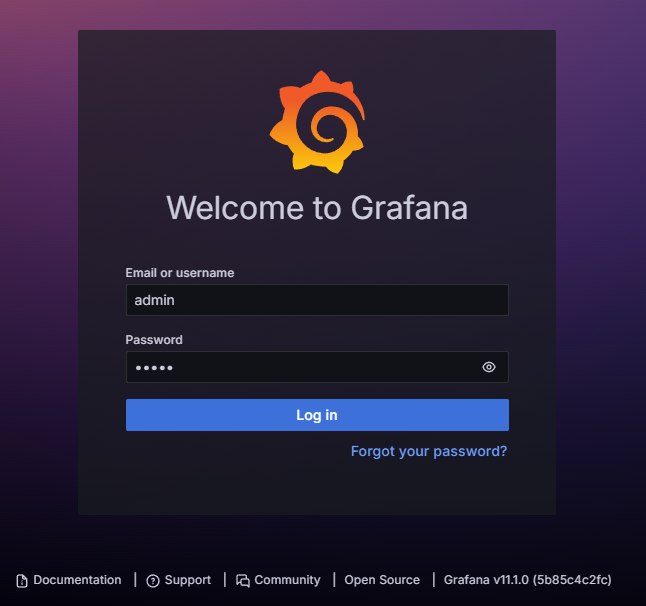

The default login and password is `admin` but you can create an official account at [Grafana](https://grafana.com/auth/sign-up/create-user) if you want. 

#### Installing Prometheus

Now, we install Prometheus. 

For Ubuntu/Debian/WSL2:

```bash
$ wget https://github.com/prometheus/prometheus/releases/download/v2.30.3/prometheus-2.30.3.linux-amd64.tar.gz
$ tar xvfz prometheus-*.tar.gz
$ cd prometheus-  # Click TAB to get the folder name
```

For macOS (using Homebrew):

```bash
$ brew update
$ brew install prometheus
```

After installation, Prometheus requires a configuration file to run correctly. 

For Ubuntu/Debian/WSL2, create a file named `prometheus.yml` in the Prometheus directory (where you extracted the tarball using the `tar` command above):

```bash
$ touch prometheus.yml
```

For macOS, the default file must be saved to `/usr/local/etc/prometheus.yml`:

```bash
$ touch /usr/local/etc/prometheus.yml
```

After you create the file, paste the following contents into it:

```yml
global:
  scrape_interval: 15s

scrape_configs:
  - job_name: 'prometheus'
    static_configs:
      - targets: ['localhost:9090']
```

Note that the configuration file might already exist in the specified locations. If so, you can paste any differences from the above snippet into the existing file. 

After saving, you can start Prometheus. 

For Ubuntu/Debian/WSL2 from the Prometheus directory, run:

```bash
$ ./prometheus --config.file=prometheus.yml
```

For macOS:

```bash
$ brew services start prometheus
```

Afterwards, you can verify it is running at `http://localhost:9090`:

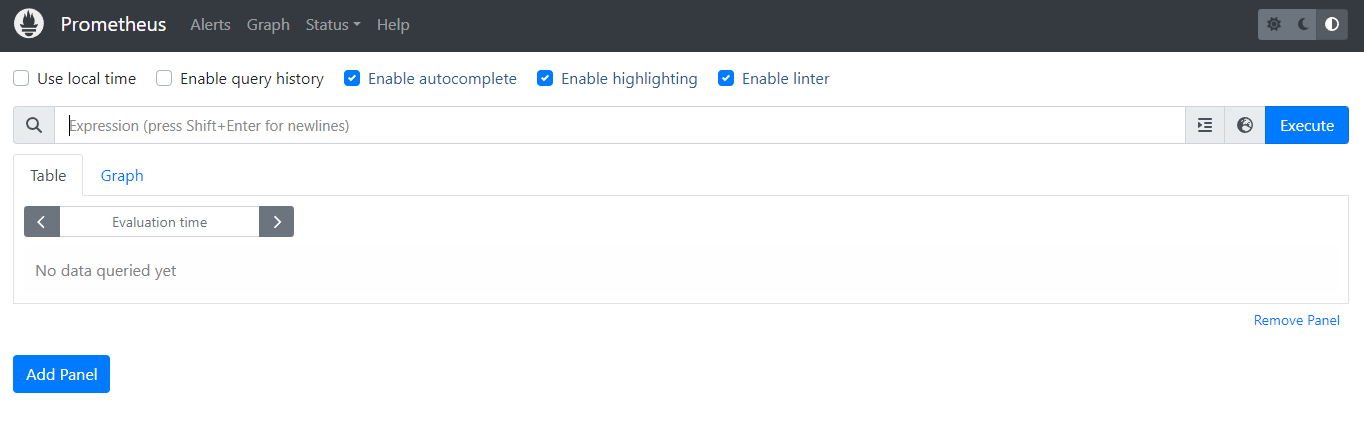

Now, we are ready to move on to model development.

### 2. Writing training code

As a sample problem, we will be predicting diamond prices using the Diamonds dataset available in Seaborn library. The data contains a mix of numeric and categorical features, requiring some pre-processing steps. So, open the `src/train.py` file and paste the code from [this script](https://github.com/BexTuychiev/grafana_model_monitoring/blob/master/src/train.py) I've hosted on GitHub. 

> Note: We will only summarize the code as the scripts are too long to display in an article. You can explore them in detail using [this GitHub repository](https://github.com/BexTuychiev/grafana_model_monitoring/) I've finalized as for the project.

The script defines a function called `train_model()` that performs the following tasks:

- Loads the Diamonds dataset from Seaborn
- Defines a Scikit-learn `ColumnTransformer` object that one-hot encodes the categorical features and scales the numeric ones. 
- Combines the `ColumnTransformer` object with a RandomForestRegressor model to create a final `model_pipeline`
- Splits the data and trains the model pipeline on the training set
- Reports the MSE performance on the test set
- Saves the trained pipeline as a pickle object with `joblib`

This script will serve as a basis for creating the REST API.

### 3. Adding drift detection methods

### 4. Serving the model as a REST API

### 5. Dockerizing the application

### 6. Adding Prometheus as a data source to Grafana

### 7. Creating a Grafana dashboard with two panels

### 8. Setting up alerts for drifts

## Best Practices For Monitoring Systems

## Conclusion
- Recap of the monitoring setup process
- Benefits of using Grafana for ML model monitoring
- Next steps and further resources